In [99]:
import os
import glob
import re
import ants

import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

in_container=True
DATADIR = "/DATA" if in_container else "/BEE/Connectome"
raw_data_path = "/ASD2/ahsan_projects/datasets/BRATS2023-PED/ASNR-MICCAI-BraTS2023-PED-Challenge-TrainingData/"
processed_data_path = f"/{DATADIR}/Users/amahmood/braintyp/brats-ped/"
segs_dir = f"/{DATADIR}/Users/amahmood/braintyp/segs/"

In [79]:
%ls -ailh $processed_data_path | grep BraTS | head

38744806003 -rw-r--r--.  1 amahmood 1001 7.3M Oct 22 16:29 BraTS-PED-00002-000.nii.gz
38744806005 -rw-r--r--.  1 amahmood 1001  31K Oct 22 16:29 BraTS-PED-00002-000_label.nii.gz
38684821896 -rw-r--r--.  1 amahmood 1001 6.9M Oct 22 16:22 BraTS-PED-00003-000.nii.gz
38684821899 -rw-r--r--.  1 amahmood 1001  31K Oct 22 16:22 BraTS-PED-00003-000_label.nii.gz
38744821050 -rw-r--r--.  1 amahmood 1001 8.5M Oct 22 16:47 BraTS-PED-00004-000.nii.gz
38744821052 -rw-r--r--.  1 amahmood 1001  48K Oct 22 16:47 BraTS-PED-00004-000_label.nii.gz
38743740420 -rw-r--r--.  1 amahmood 1001  13M Oct 22 16:25 BraTS-PED-00006-000.nii.gz
38744776201 -rw-r--r--.  1 amahmood 1001  33K Oct 22 16:25 BraTS-PED-00006-000_label.nii.gz
38744806001 -rw-r--r--.  1 amahmood 1001  11M Oct 22 16:29 BraTS-PED-00008-000.nii.gz
38744806004 -rw-r--r--.  1 amahmood 1001  32K Oct 22 16:29 BraTS-PED-00008-000_label.nii.gz
grep: write error: Broken pipe


In [65]:
# dirs = glob.glob(f"{raw_data_path}/*/*")
# ages = [p.split("/")[-1] for p in dirs]
# Counter(ages)

In [76]:
img = ants.image_read(f"{segs_dir}/BraTS-PED-00020-000.nii.gz")
img.plot()

img.sum()

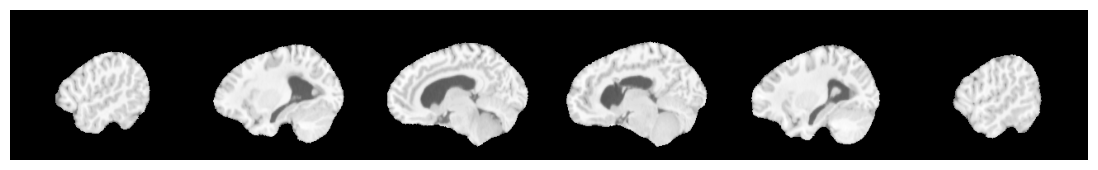

In [91]:
img,_ = ants.image_read(f"{processed_data_path}/BraTS-PED-00020-000.nii.gz").split_channels()
img.plot(nslices=6)

In [87]:
img.std()

0.2437684

### WM Segmentations fail, so we can use simple heuristics

In [85]:
img_paths = glob.glob(f"{processed_data_path}/BraTS*[0-9].nii.gz")
subids = [re.search(r"(BraTS.*)\.nii", p).group(1) for p in img_paths]
len(img_paths), img_paths[0], subids[0]

(99,
 '//DATA/Users/amahmood/braintyp/brats-ped/BraTS-PED-00111-000.nii.gz',
 'BraTS-PED-00111-000')

In [100]:
%%time
t1_means, t1_stds = [], []
t2_means, t2_stds = [], []

for p in tqdm(img_paths):
    img = ants.image_read(p)
    t1,t2 = img.split_channels()
    t1_means.append(t1.mean())
    t1_stds.append(t1.std())

    t2_means.append(t2.mean())
    t2_stds.append(t2.std())

100%|██████████| 99/99 [01:18<00:00,  1.27it/s]

CPU times: user 1min 12s, sys: 2.82 s, total: 1min 14s
Wall time: 1min 18s


In [103]:
t1_wm_means = pd.Series(t1_means, index=subids)
t2_wm_means = pd.Series(t2_means, index=subids)

<Axes: >

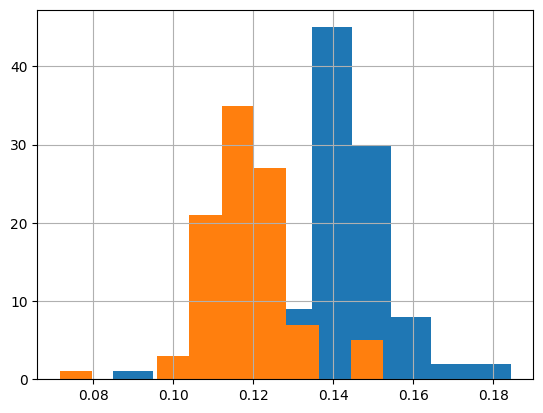

In [120]:
t1_wm_means.hist()
t2_wm_means.hist()

In [104]:
t1_wm_stds = pd.Series(t1_stds, index=subids)
t2_wm_stds = pd.Series(t2_stds, index=subids)

<Axes: >

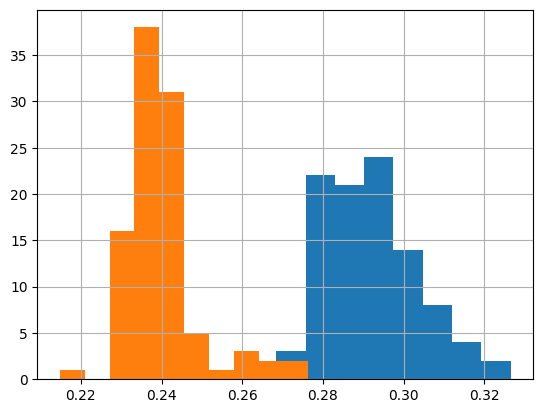

In [121]:
t1_wm_stds.hist()
t2_wm_stds.hist()

In [105]:
t1_mu = t1_wm_means.dropna().mean()
t1_std = t1_wm_means.dropna().std()

print(f"T1 Means: mu: {t1_mu:.3f} w/ std {t1_std:.3f}")

T1 Means: mu: 0.144 w/ std 0.012


In [106]:
t1_stds_mu = t1_wm_stds.mean()
t1_stds_std = t1_wm_stds.std()

print(f"T1 Stds: {t1_stds_mu:.3f} w/ std {t1_stds_std:.3f}")

T1 Stds: 0.292 w/ std 0.012


In [129]:
mult = 1.5
t1_mu_candidates = (t1_wm_means > (t1_mu + mult*t1_std)) | (t1_wm_means < (t1_mu - mult*t1_std))
t1_std_candidates = (t1_wm_stds > (t1_stds_mu + mult*t1_stds_std)) | (t1_wm_stds < (t1_stds_mu - mult*t1_stds_std))
t1_candidates = t1_mu_candidates | t1_std_candidates
t1_outliers = np.argwhere(t1_candidates.to_numpy()).flatten()
len(t1_outliers)

18

In [130]:
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

99

BraTS-PED-00003-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00003-000.nii.gz


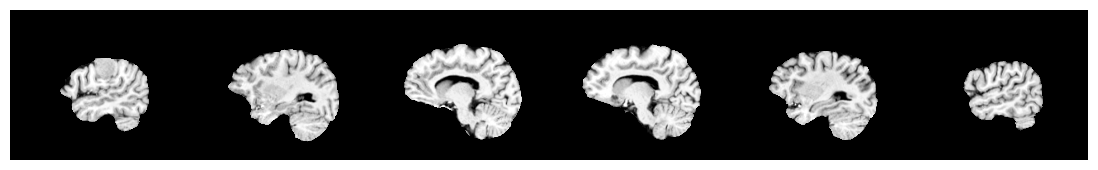

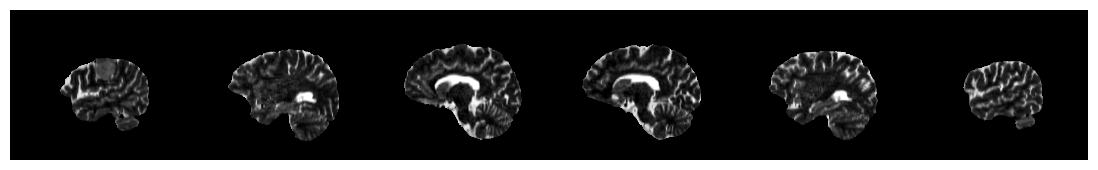

BraTS-PED-00123-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00123-000.nii.gz


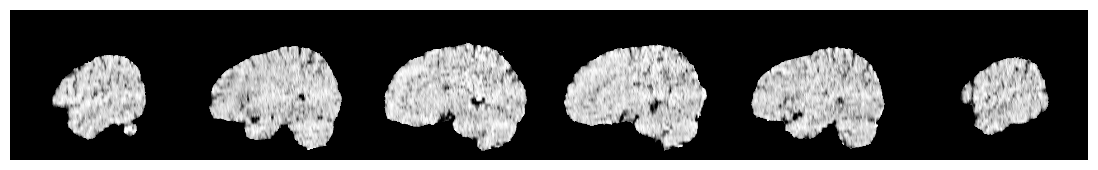

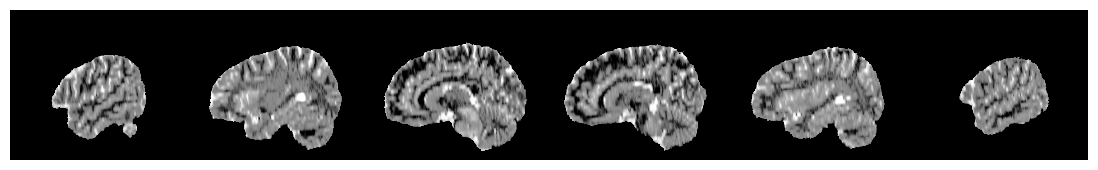

BraTS-PED-00006-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00006-000.nii.gz


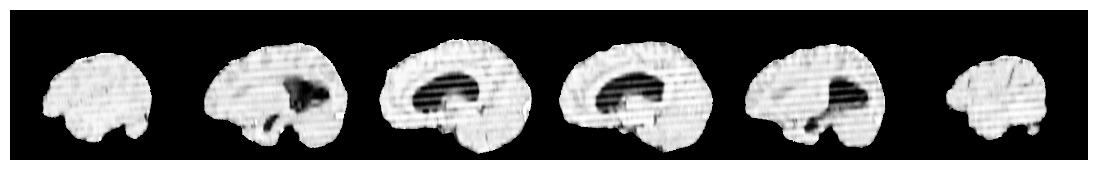

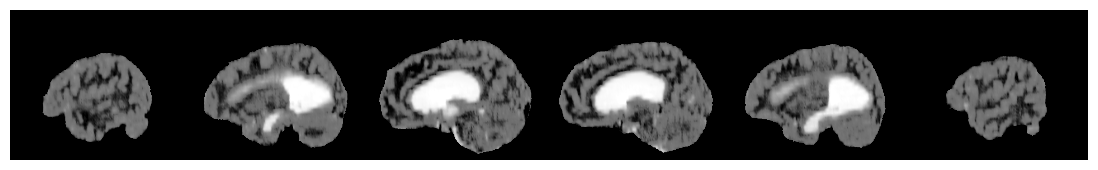

BraTS-PED-00037-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00037-000.nii.gz


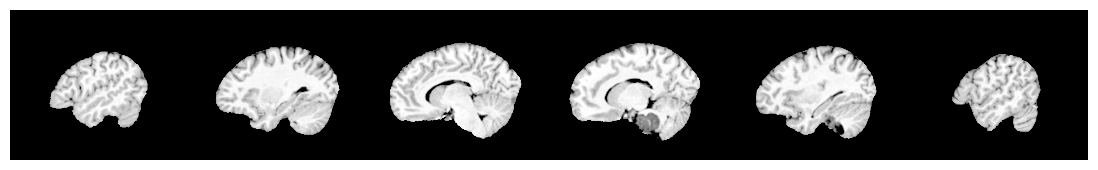

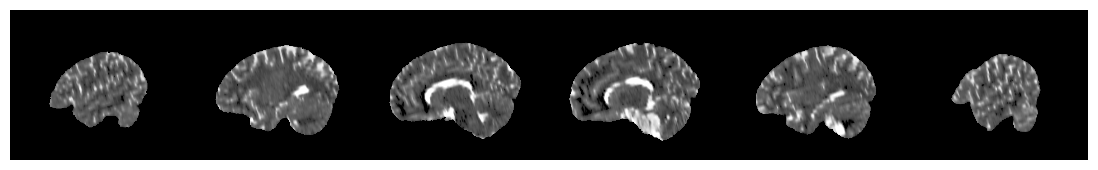

BraTS-PED-00124-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00124-000.nii.gz


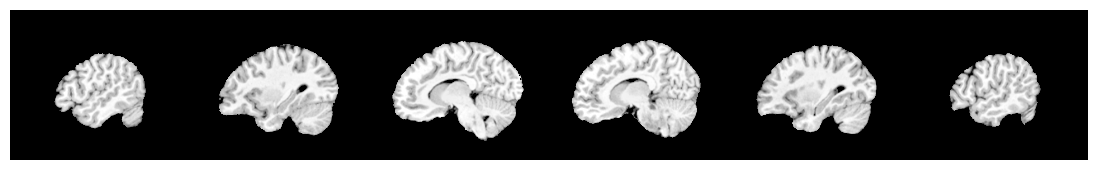

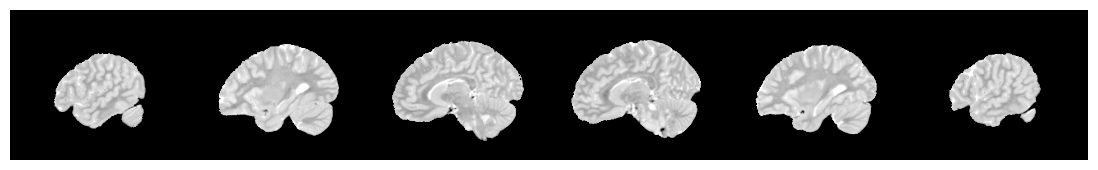

BraTS-PED-00087-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00087-000.nii.gz


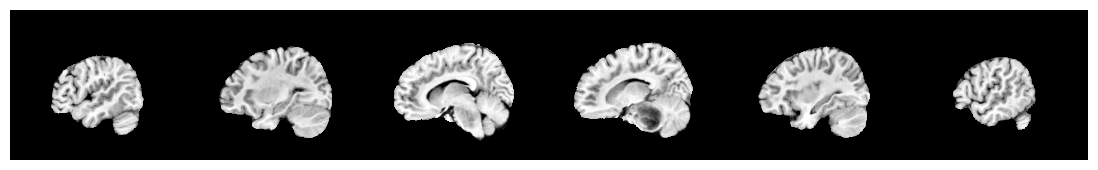

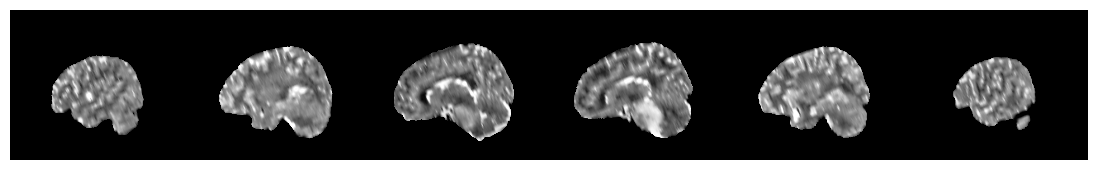

BraTS-PED-00131-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00131-000.nii.gz


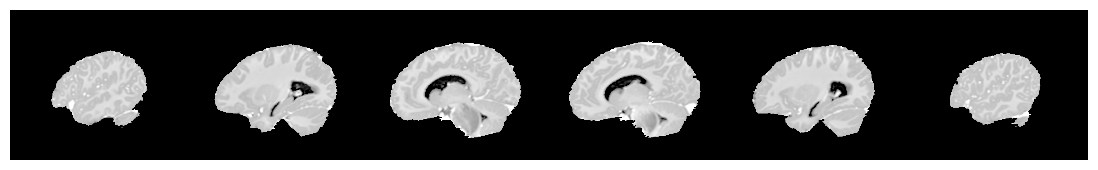

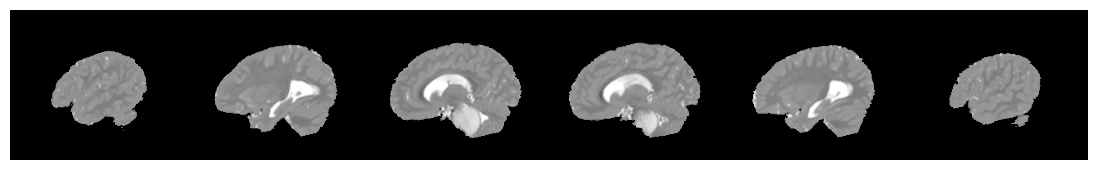

BraTS-PED-00002-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00002-000.nii.gz


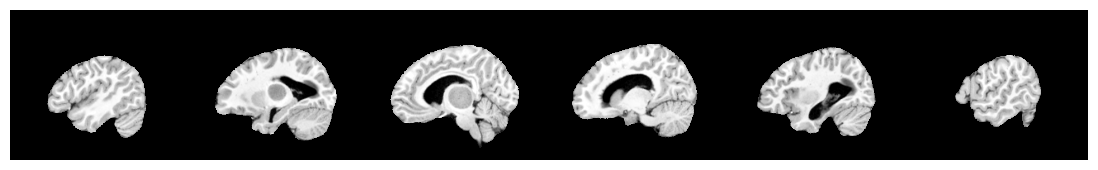

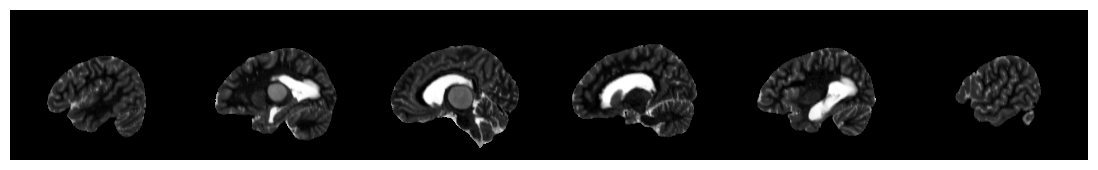

BraTS-PED-00115-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00115-000.nii.gz


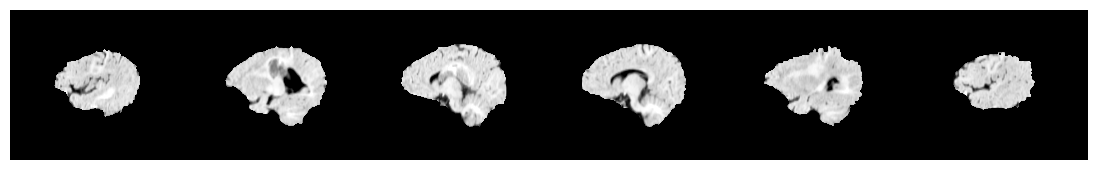

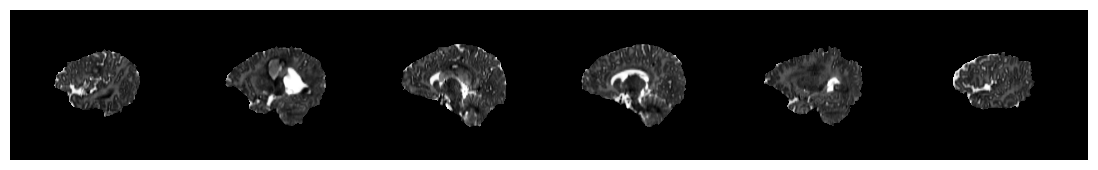

BraTS-PED-00106-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00106-000.nii.gz


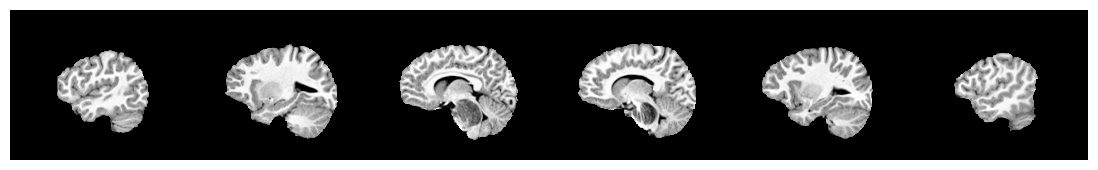

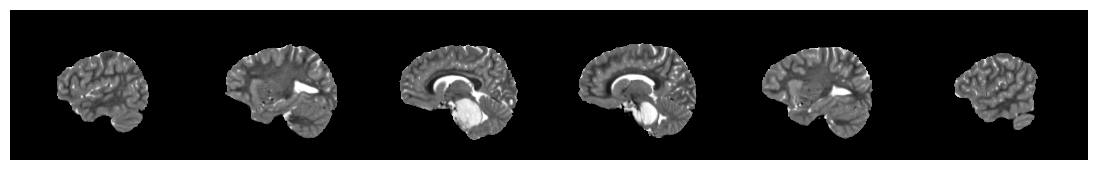

BraTS-PED-00097-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00097-000.nii.gz


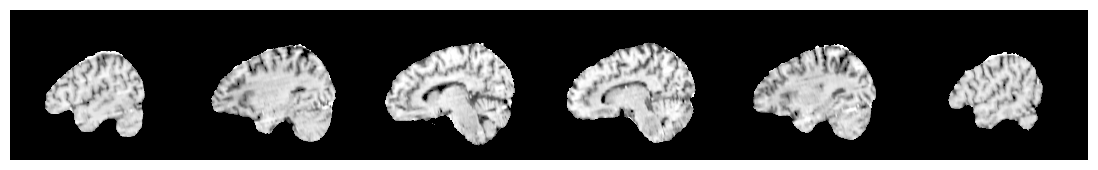

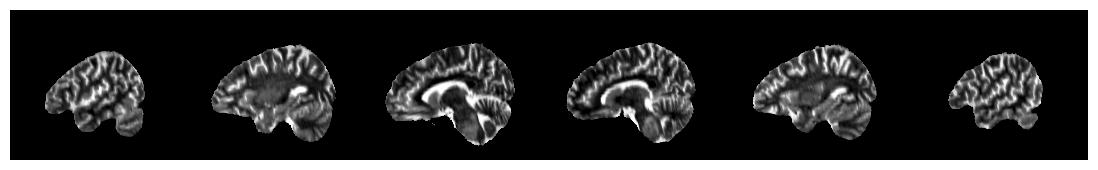

BraTS-PED-00055-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00055-000.nii.gz


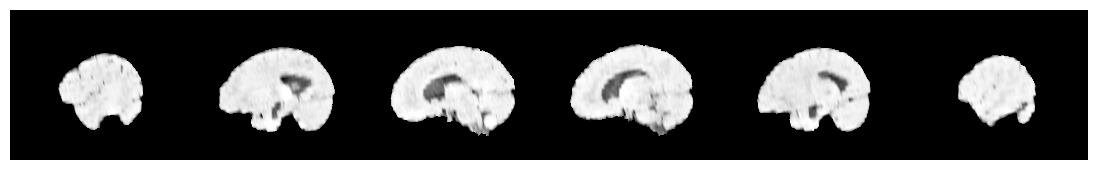

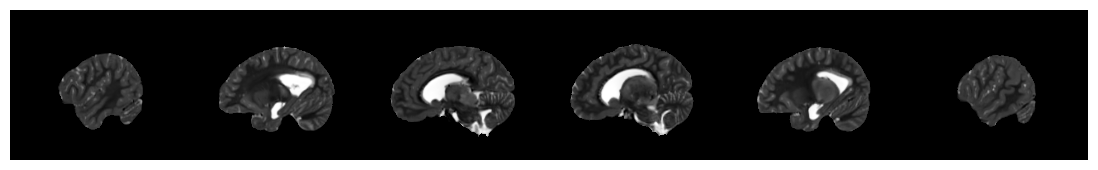

BraTS-PED-00120-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00120-000.nii.gz


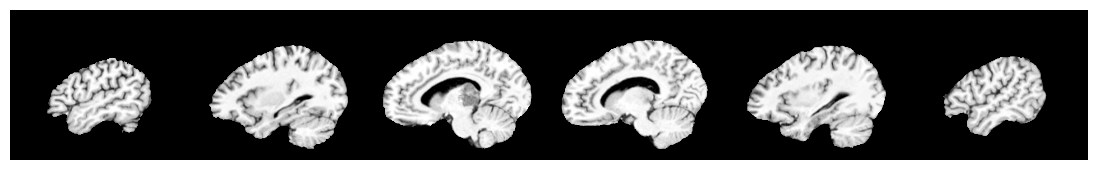

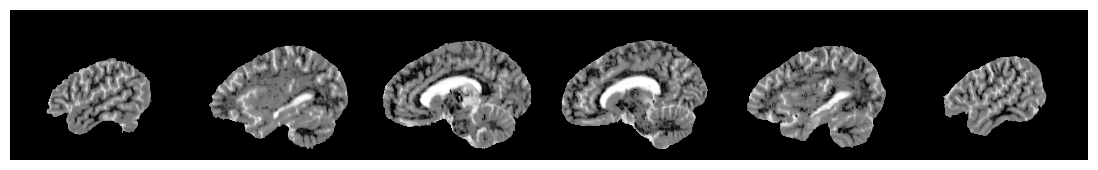

BraTS-PED-00121-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00121-000.nii.gz


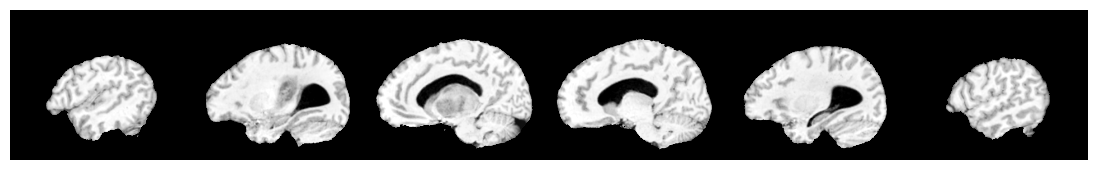

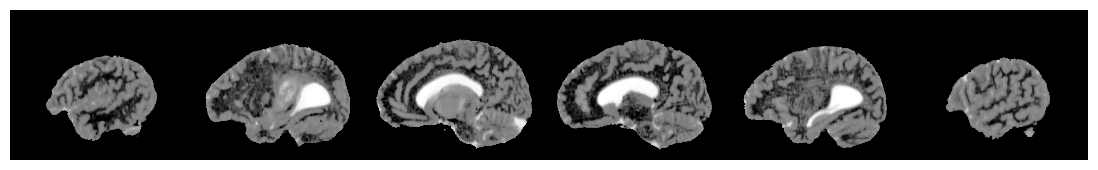

BraTS-PED-00137-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00137-000.nii.gz


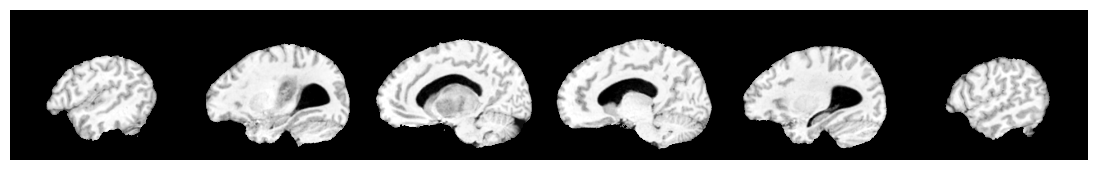

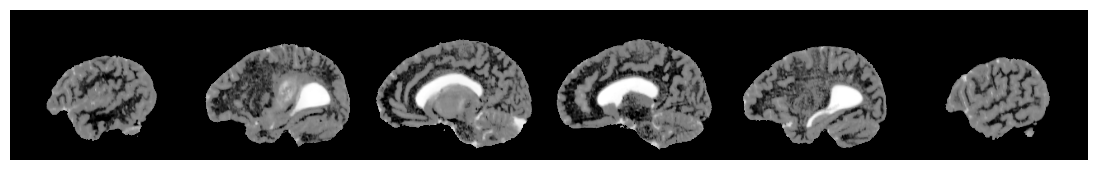

BraTS-PED-00047-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00047-000.nii.gz


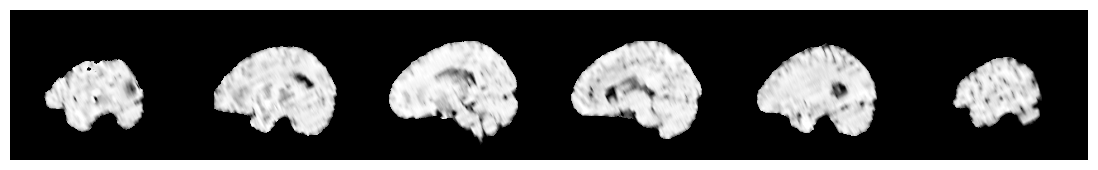

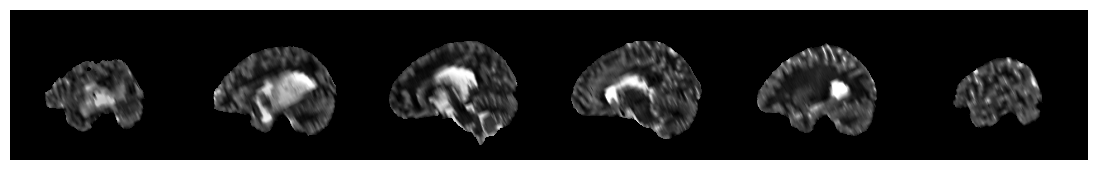

BraTS-PED-00118-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00118-000.nii.gz


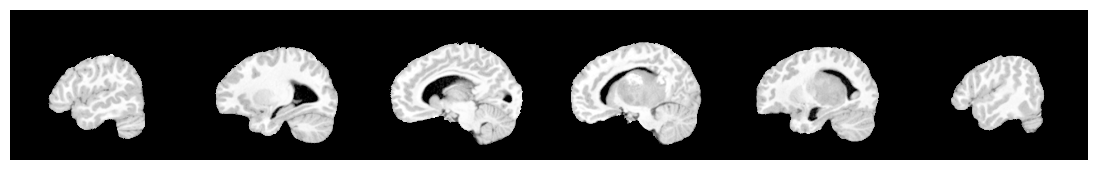

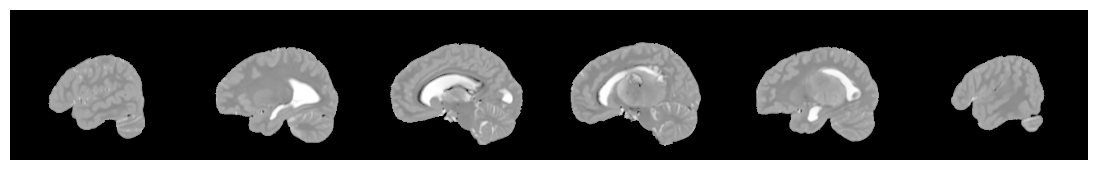

BraTS-PED-00138-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00138-000.nii.gz


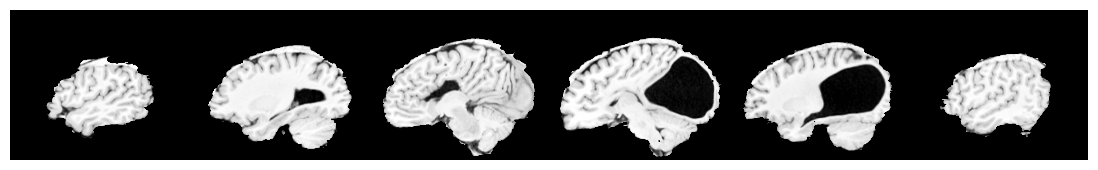

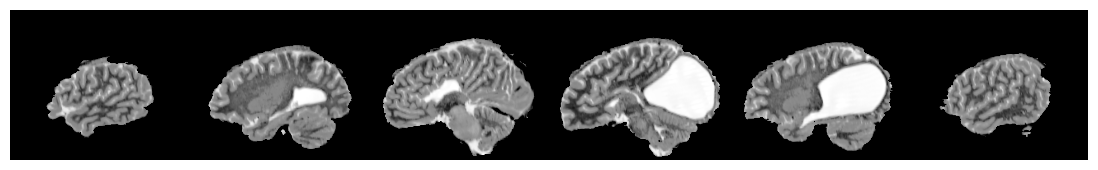

In [131]:
for tidx in t1_outliers:
    sid = t1_wm_means.index[tidx]
#     path = glob.glob(f"{raw_data_path}/{sid[4:]}/*/anat/*")[-1]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")

    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### T2

In [111]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [112]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.118 w/ std 0.011


In [113]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.240 w/ std 0.009


In [125]:
mult = 2
t2_mu_candidates = (t2_wm_means > (t2_mu + mult*t2_std)) | (t2_wm_means < (t2_mu - mult*t2_std))
t2_std_candidates = (t2_wm_stds > (t2_stds_mu + mult*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - mult*t2_stds_std))
t2_candidates = t2_mu_candidates | t2_std_candidates
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

10

BraTS-PED-00021-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00021-000.nii.gz


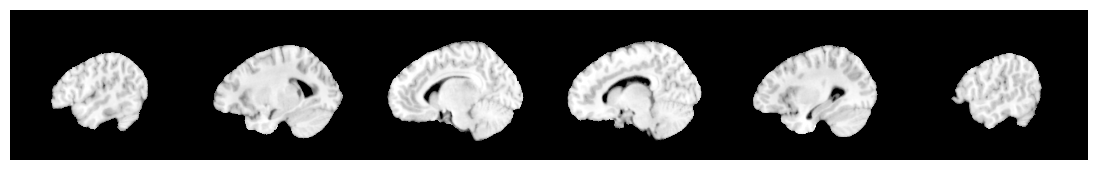

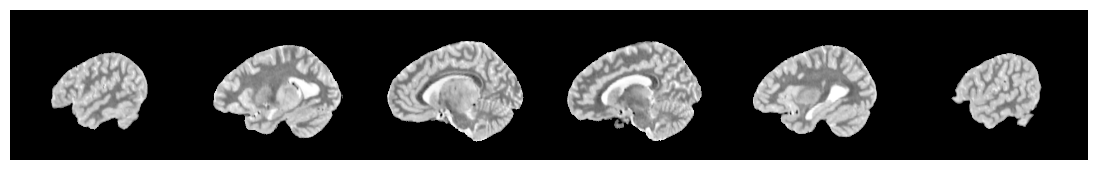

BraTS-PED-00067-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00067-000.nii.gz


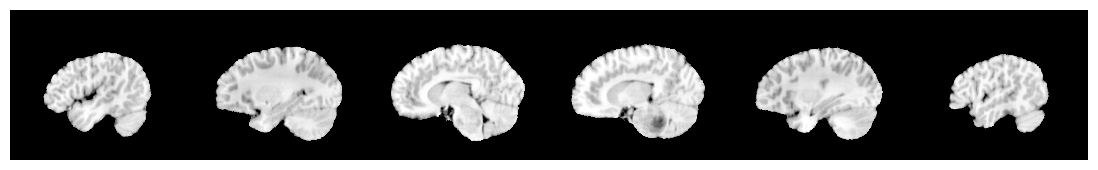

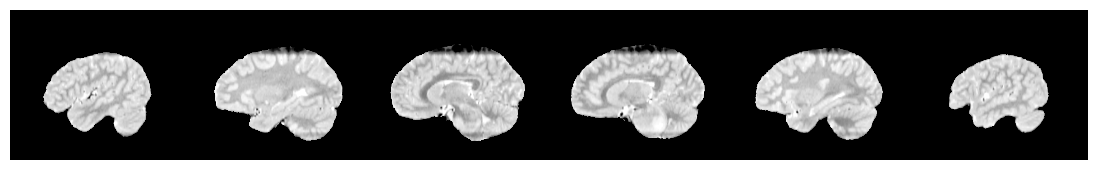

BraTS-PED-00006-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00006-000.nii.gz


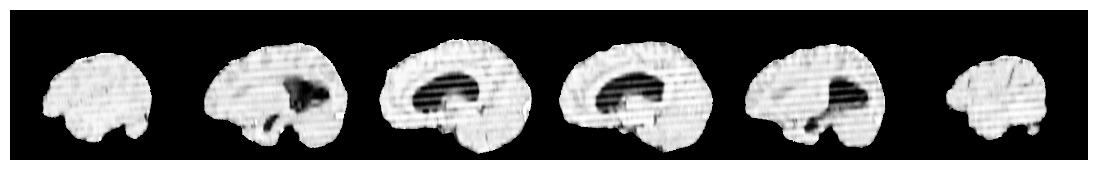

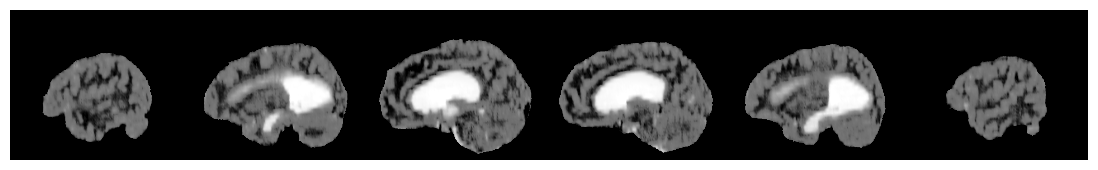

BraTS-PED-00087-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00087-000.nii.gz


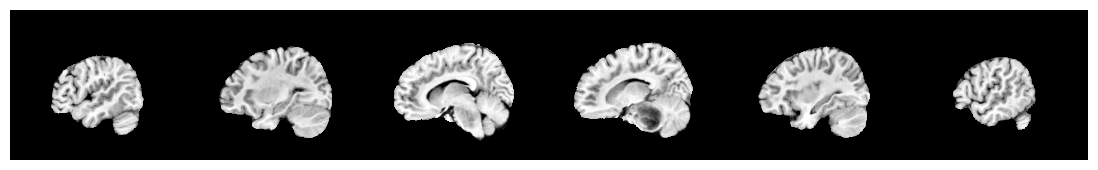

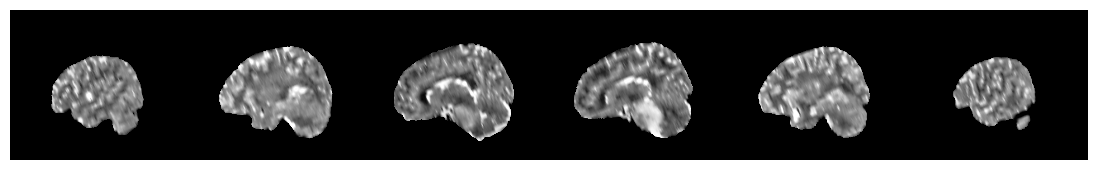

BraTS-PED-00115-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00115-000.nii.gz


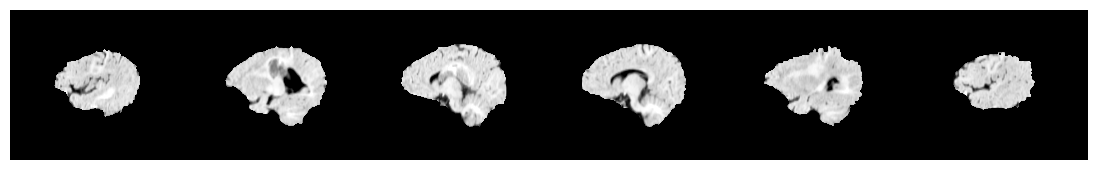

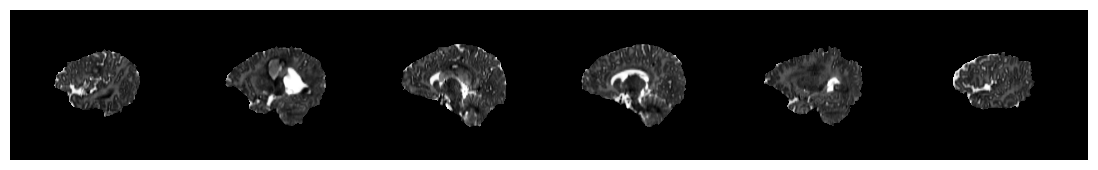

BraTS-PED-00121-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00121-000.nii.gz


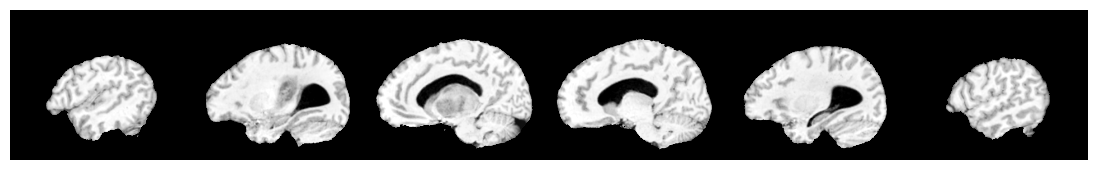

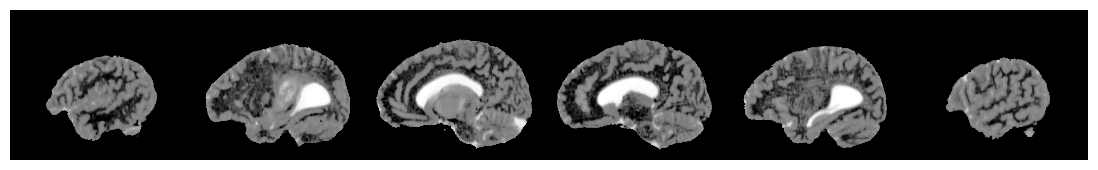

BraTS-PED-00072-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00072-000.nii.gz


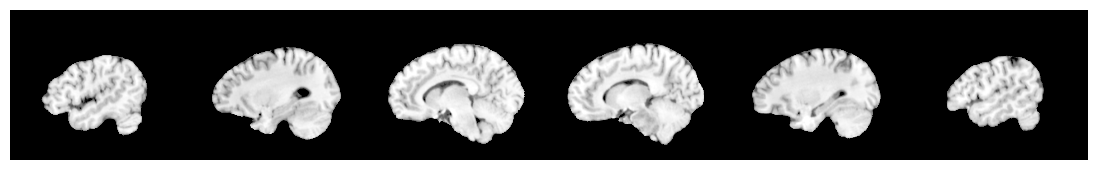

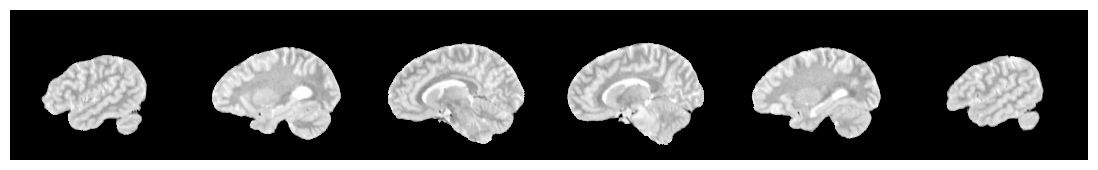

BraTS-PED-00137-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00137-000.nii.gz


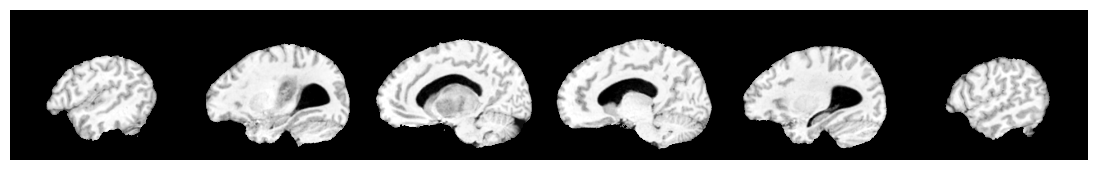

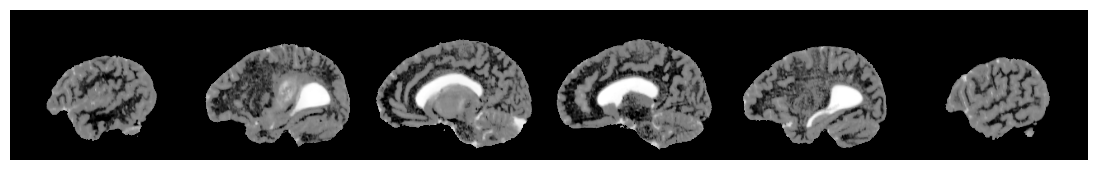

BraTS-PED-00129-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00129-000.nii.gz


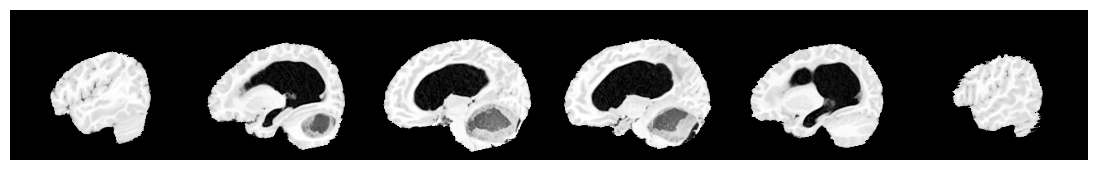

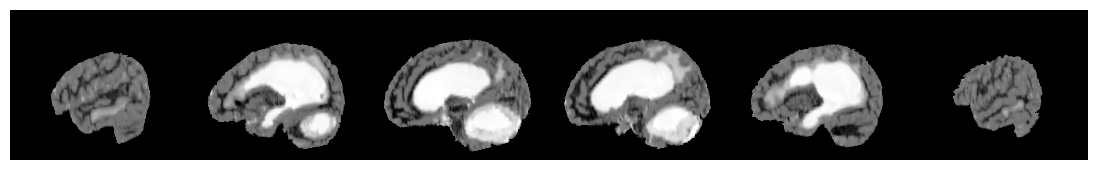

BraTS-PED-00138-000: //DATA/Users/amahmood/braintyp/brats-ped//BraTS-PED-00138-000.nii.gz


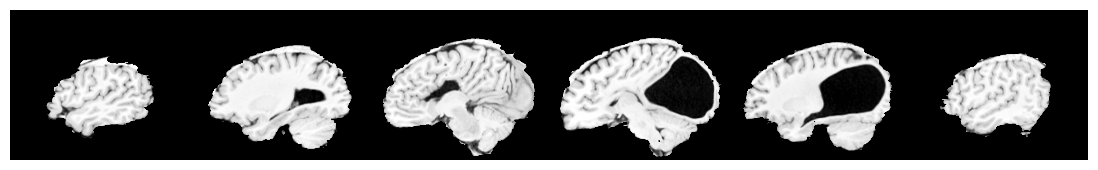

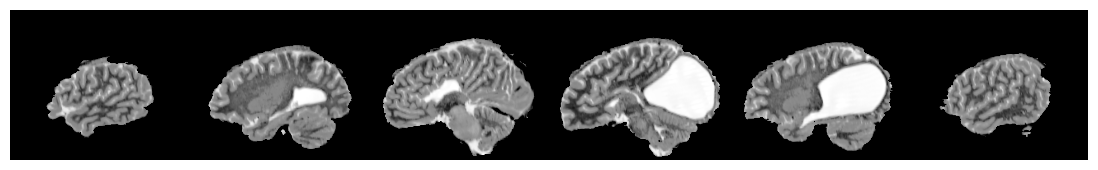

In [127]:
for tidx in t2_outliers:
    sid = t2_wm_means.index[tidx]
    preproc_path = f"{processed_data_path}/{sid}.nii.gz"
    print(f"{sid}: {preproc_path}")
    
#     t1_outlier_img = ants.image_read(path)
#     t1_outlier_img.plot(nslices=6)
    
    t1_outlier_img_procd, t2_outlier_img_procd = ants.image_read(preproc_path).split_channels()
    t1_outlier_img_procd.plot(nslices=6,  scale=(0.01,0.99))    
    t2_outlier_img_procd.plot(nslices=6, scale=(0.01,0.99))

### None of the outliers seem to be QC/acquistion failures. Mostly fat artifacts is my guess

In [22]:
pd.Series(t1_wm_means.dropna().index)

0      EBDSC0038-1-1
1      EBDSC0233-2-1
2      EBDSC0038-2-1
3      EBDSC0042-2-1
4      EBDSC0087-2-1
           ...      
112    EBDST0002-1-1
113    EBDSC0461-1-1
114    EBDSC0499-1-1
115    EBDSC0552-1-1
116    EBDSC0553-1-1
Length: 117, dtype: object

In [23]:
t1_wm_means.dropna().astype(str).reset_index()

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


index           0
0    EBDSC0038-1-1   0.8325984
1    EBDSC0233-2-1  0.86529416
2    EBDSC0038-2-1   0.8385045
3    EBDSC0042-2-1    0.817958
4    EBDSC0087-2-1  0.90995663
..             ...         ...
112  EBDST0002-1-1  0.83672523
113  EBDSC0461-1-1   0.8405562
114  EBDSC0499-1-1     0.83494
115  EBDSC0552-1-1   0.8689795
116  EBDSC0553-1-1   0.8745739

[117 rows x 2 columns]

In [132]:
# brats_ped_passing_keys = pd.Series(t1_wm_means.dropna().index)
# brats_ped_passing_keys.to_csv('../split-keys/brats_keys.txt', header=None, index=None)